Epoch 1/50, Loss: 0.1089
Epoch 2/50, Loss: 0.0785
Epoch 3/50, Loss: 0.0667
Epoch 4/50, Loss: 0.0658
Epoch 5/50, Loss: 0.0644
Epoch 6/50, Loss: 0.0632
Epoch 7/50, Loss: 0.0628
Epoch 8/50, Loss: 0.0623
Epoch 9/50, Loss: 0.0625
Epoch 10/50, Loss: 0.0615
Epoch 11/50, Loss: 0.0604
Epoch 12/50, Loss: 0.0603
Epoch 13/50, Loss: 0.0603
Epoch 14/50, Loss: 0.0616
Epoch 15/50, Loss: 0.0603
Epoch 16/50, Loss: 0.0597
Epoch 17/50, Loss: 0.0598
Epoch 18/50, Loss: 0.0600
Epoch 19/50, Loss: 0.0605
Epoch 20/50, Loss: 0.0599
Epoch 21/50, Loss: 0.0593
Epoch 22/50, Loss: 0.0586
Epoch 23/50, Loss: 0.0587
Epoch 24/50, Loss: 0.0586
Epoch 25/50, Loss: 0.0587
Epoch 26/50, Loss: 0.0580
Epoch 27/50, Loss: 0.0585
Epoch 28/50, Loss: 0.0585
Epoch 29/50, Loss: 0.0575
Epoch 30/50, Loss: 0.0574
Epoch 31/50, Loss: 0.0572
Epoch 32/50, Loss: 0.0564
Epoch 33/50, Loss: 0.0563
Epoch 34/50, Loss: 0.0560
Epoch 35/50, Loss: 0.0552
Epoch 36/50, Loss: 0.0539
Epoch 37/50, Loss: 0.0545
Epoch 38/50, Loss: 0.0552
Epoch 39/50, Loss: 0.

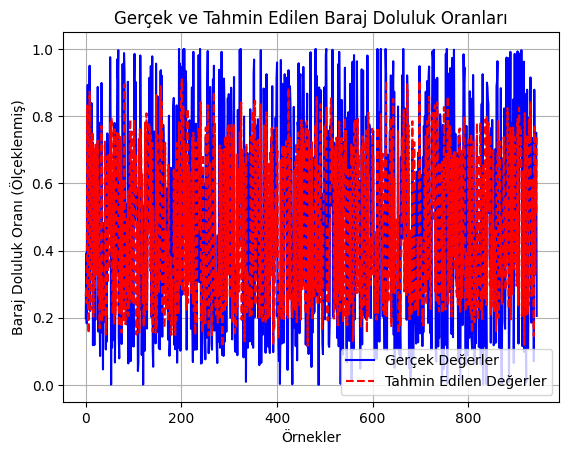

In [3]:
# FEDFORMER MODELİ
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
# Excel verilerini yükleme
data = pd.read_excel('alibeyBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeedmean', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırın
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, :-1]
        label = data[i + seq_length, -1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 30  # 30 günlük geçmiş veri kullanacağız
data_array = data[features + [target]].values
X, y = create_sequences(data_array, seq_length)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# FEDformer modelini tanımlayın
class FEDformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FEDformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Son zaman adımını alın
        out = self.fc(out)
        return out

# Model oluşturma
input_size = len(features)
hidden_size = 64
output_size = 1

model = FEDformer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(output.numpy())

# Hesaplamalar
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)


epsilon = 1e-5  # Çok küçük bir değer
valid_indices = y_true > epsilon  # Sadece bu koşulu sağlayanları al
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]

# Filtrelenmiş değerler ile MAPE hesaplaması
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Modelin tahmin yapması
def predict(data, model, scaler, seq_length):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[-seq_length:, :-1].reshape(1, seq_length, -1), dtype=torch.float32)
        prediction = model(inputs).item()
    return scaler.inverse_transform([[0] * (len(features)) + [prediction]])[0, -1]
    plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()



Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeedmean',
       'sealevelpressure', 'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 1/10, Train Loss: 0.14054945676966948, Test Loss: 0.037336411849154455
Train MSE: 0.14080074930954076, Test MSE: 0.03384682104649671
Train MAPE: 173.61844778060913%, Test MAPE: inf%
Train MAE: 0.3060957120787748, Test MAE: 0.15773113126444638
Train RMSE: 0.37523425924286385, Test RMSE: 0.18397505550073007
Train R²: -0.6622341713589219, Test R²: -0.37511990271179085
Training Time: 60.38566613197327 seconds, Inference Time: 2.92887282371521 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 2/10, Train Loss: 0.08784530497225071, Test Loss: 0.02628510425749578
Train MSE: 0.08784970493911672, Test MSE: 0.019632474177353313
Train MAPE: 62.45740056037903%, Test MAPE: inf%
Train MAE: 0.1873891209317711, Test MAE: 0.1010841866183039
Train RMSE: 0.29639450895574415, Test RMSE: 0.14011593120467533
Train R²: -0.03711650832602209, Test R²: 0.20237691026678728
Training Time: 60.71513104438782 seconds, Inference Time: 3.2303757667541504 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 3/10, Train Loss: 0.07383446275101353, Test Loss: 0.02193438854393255
Train MSE: 0.07427022032688703, Test MSE: 0.016195090703142487
Train MAPE: 64.68193531036377%, Test MAPE: inf%
Train MAE: 0.15618004330204227, Test MAE: 0.0935320827162737
Train RMSE: 0.27252563242177247, Test RMSE: 0.1272599336128323
Train R²: 0.1231971509590376, Test R²: 0.34203003816752864
Training Time: 58.68585205078125 seconds, Inference Time: 2.9682302474975586 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 4/10, Train Loss: 0.07745144333414457, Test Loss: 0.016165377535799053
Train MSE: 0.07772112333724224, Test MSE: 0.012108142836777034
Train MAPE: 61.642640829086304%, Test MAPE: inf%
Train MAE: 0.15111097464921852, Test MAE: 0.0841483104790951
Train RMSE: 0.278785084495642, Test RMSE: 0.11003700666947022
Train R²: 0.08245724769867124, Test R²: 0.5080735004077239
Training Time: 60.6140820980072 seconds, Inference Time: 3.555309295654297 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 5/10, Train Loss: 0.0778358614792254, Test Loss: 0.009231216957375995
Train MSE: 0.07810941568079287, Test MSE: 0.00812670153920189
Train MAPE: 53.48401069641113%, Test MAPE: inf%
Train MAE: 0.14596269544976967, Test MAE: 0.07610470444744087
Train RMSE: 0.2794806177193561, Test RMSE: 0.0901482198337931
Train R²: 0.07787323230747512, Test R²: 0.6698304690238629
Training Time: 58.81711483001709 seconds, Inference Time: 2.9322221279144287 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 6/10, Train Loss: 0.07663887340782417, Test Loss: 0.005680498285408631
Train MSE: 0.07688451274486909, Test MSE: 0.00505034235858719
Train MAPE: 36.60396337509155%, Test MAPE: inf%
Train MAE: 0.13476087725659072, Test MAE: 0.0571178351688143
Train RMSE: 0.27728056683595603, Test RMSE: 0.07106576080354864
Train R²: 0.09233391896344034, Test R²: 0.7948159951783575
Training Time: 60.37446188926697 seconds, Inference Time: 3.453472137451172 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 7/10, Train Loss: 0.07989581563096079, Test Loss: 0.005302390206596006
Train MSE: 0.0801151536366215, Test MSE: 0.0047383227971285295
Train MAPE: 35.32749116420746%, Test MAPE: inf%
Train MAE: 0.1347311651972111, Test MAE: 0.05627913465245794
Train RMSE: 0.28304620406679454, Test RMSE: 0.06883547629768047
Train R²: 0.05419433723540146, Test R²: 0.8074926453254359
Training Time: 57.94392251968384 seconds, Inference Time: 2.990405559539795 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 8/10, Train Loss: 0.07623934907260937, Test Loss: 0.005195013827209263
Train MSE: 0.07581150564381688, Test MSE: 0.00465080618866609
Train MAPE: 36.59329414367676%, Test MAPE: inf%
Train MAE: 0.12697370920177925, Test MAE: 0.05601000910720382
Train RMSE: 0.2753388923559781, Test RMSE: 0.06819681949083908
Train R²: 0.1050013875545246, Test R²: 0.8110482474881682
Training Time: 60.43524122238159 seconds, Inference Time: 2.1848790645599365 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 9/10, Train Loss: 0.06927067567206298, Test Loss: 0.004399302796197222
Train MSE: 0.06973045382587924, Test MSE: 0.004015464577545717
Train MAPE: 34.14473533630371%, Test MAPE: inf%
Train MAE: 0.1211150332547283, Test MAE: 0.05089338367454644
Train RMSE: 0.2640652453956772, Test RMSE: 0.06336769348450137
Train R²: 0.17679171664828697, Test R²: 0.8368607423535619
Training Time: 58.72436547279358 seconds, Inference Time: 2.1658108234405518 seconds


<ipython-input-8-aaec454ea55d>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 10/10, Train Loss: 0.07340869732002762, Test Loss: 0.0035341259578049893
Train MSE: 0.07279297678925209, Test MSE: 0.0032284487775080637
Train MAPE: 31.05577528476715%, Test MAPE: inf%
Train MAE: 0.12077795717621716, Test MAE: 0.04663247285315242
Train RMSE: 0.2698017360753116, Test RMSE: 0.05681944013722824
Train R²: 0.14063686416878507, Test R²: 0.8688354169882552
Training Time: 59.156444787979126 seconds, Inference Time: 3.8205015659332275 seconds


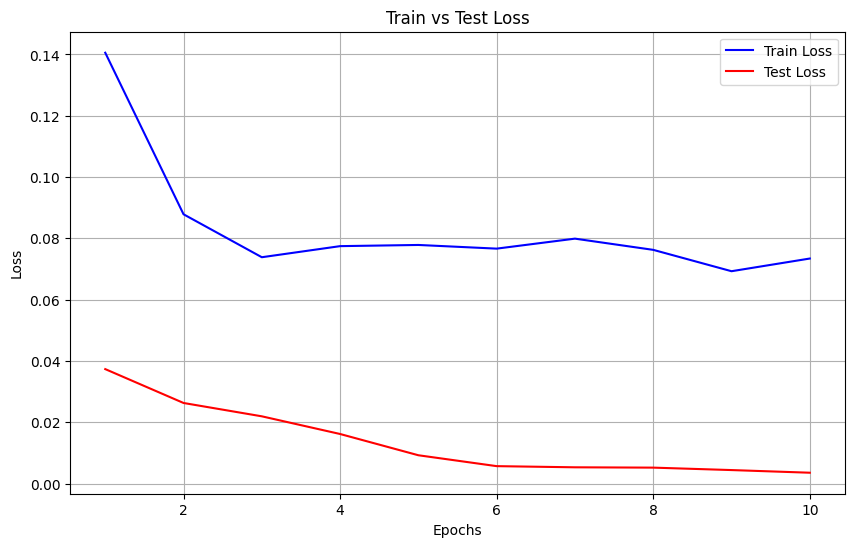

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # TFT MODELİ

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "alibeyBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Yapıcı metodun doğru tanımı
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Veri setinin uzunluğunu döner
        return len(self.X)

    def __getitem__(self, index):  # Belirtilen indeks için X ve y değerlerini döner
        return self.X[index], self.y[index]

# Dataset ve DataLoader oluşturma
train_dataset = TimeSeriesDataset(X_train, y_train)  # Burada hata alınmamalı
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Düzeltildi
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 10  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.1199
Epoch 2/50, Loss: 0.0764
Epoch 3/50, Loss: 0.0714
Epoch 4/50, Loss: 0.0691
Epoch 5/50, Loss: 0.0684
Epoch 6/50, Loss: 0.0676
Epoch 7/50, Loss: 0.0662
Epoch 8/50, Loss: 0.0658
Epoch 9/50, Loss: 0.0653
Epoch 10/50, Loss: 0.0656
Epoch 11/50, Loss: 0.0646
Epoch 12/50, Loss: 0.0656
Epoch 13/50, Loss: 0.0646
Epoch 14/50, Loss: 0.0640
Epoch 15/50, Loss: 0.0634
Epoch 16/50, Loss: 0.0635
Epoch 17/50, Loss: 0.0635
Epoch 18/50, Loss: 0.0636
Epoch 19/50, Loss: 0.0629
Epoch 20/50, Loss: 0.0632
Epoch 21/50, Loss: 0.0630
Epoch 22/50, Loss: 0.0635
Epoch 23/50, Loss: 0.0641
Epoch 24/50, Loss: 0.0636
Epoch 25/50, Loss: 0.0626
Epoch 26/50, Loss: 0.0622
Epoch 27/50, Loss: 0.0627
Epoch 28/50, Loss: 0.0618
Epoch 29/50, Loss: 0.0621
Epoch 30/50, Loss: 0.0624
Epoch 31/50, Loss: 0.0619
Epoch 32/50, Loss: 0.0617
Epoch 33/50, Loss: 0.0623
Epoch 34/50, Loss: 0.0616
Epoch 35/50, Loss: 0.0620
Epoch 36/50, Loss: 0.0618
Epoch 37/50, Loss: 0.0617
Epoch 38/50, Loss: 0.0621
Epoch 39/50, Loss: 0.

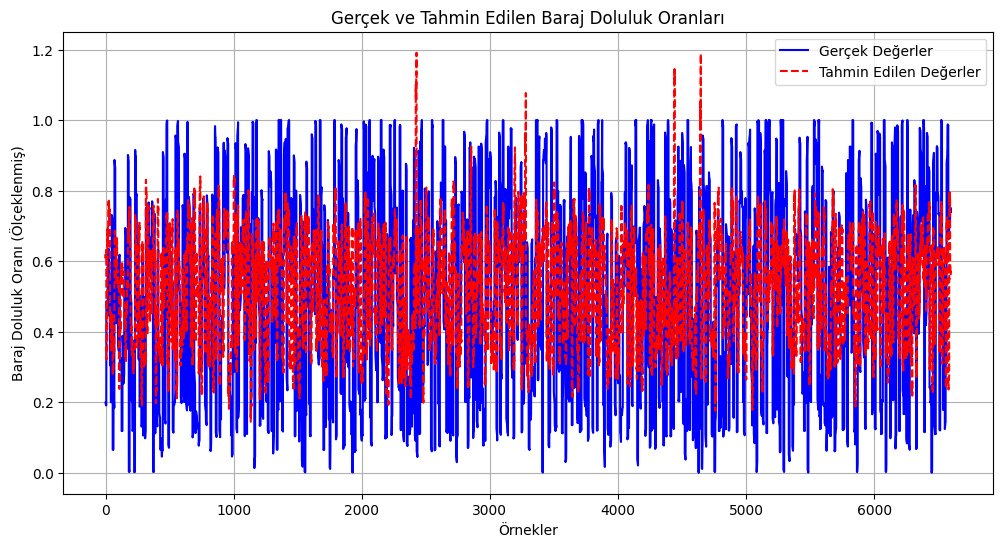

In [9]:
# İNFORMER
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

data = pd.read_excel('alibeyBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeedmean', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'


scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırma
def create_sequences(data, input_len, pred_len):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i + input_len, :-1])
        y.append(data[i + input_len:i + input_len + pred_len, -1])
    return np.array(X), np.array(y)

input_len = 30  # Geçmiş 30 gün
pred_len = 7    # Tahmin edilen 7 gün
data_array = data[features + [target]].values
X, y = create_sequences(data_array, input_len, pred_len)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Informer modeli
class Informer(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, d_model, num_heads, num_layers):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_len * input_size, pred_len)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        x = x.view(batch_size, seq_len * input_size)  # Flatten for linear layer
        x = self.fc(x)
        return x

# Model oluşturma
input_size = len(features)
d_model = 64
num_heads = 4
num_layers = 2

model = Informer(input_size, seq_len=input_len, pred_len=pred_len,
                 d_model=d_model, num_heads=num_heads, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(output.numpy().flatten())

# Performans metrikleri
# Performans metrikleri
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Tahmin ve görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()


Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeedmean',
       'sealevelpressure', 'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-13-b1f94f5f9da0>:158: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 1/3, Train Loss: 0.051626388587195565, Test Loss: 0.0063561864770140105
Train MSE: 0.05194704885762198, Test MSE: 0.006532413139802841
Train MAPE: 120.67416906356812%, Test MAPE: inf%
Train MAE: 0.15228743680216583, Test MAE: 0.06654052406820095
Train RMSE: 0.22791895238795298, Test RMSE: 0.08082334526486046
Train R²: 0.38673508389816713, Test R²: 0.7346028063037645
Training time for epoch 1: 57.46 seconds
Inference time for epoch 1: 0.58 seconds


<ipython-input-13-b1f94f5f9da0>:158: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 2/3, Train Loss: 0.0012484045139529, Test Loss: 0.0018970428075255385
Train MSE: 0.0012503128633108444, Test MSE: 0.001909431596262601
Train MAPE: 20.414309203624725%, Test MAPE: inf%
Train MAE: 0.026061682243746477, Test MAE: 0.03307419607543156
Train RMSE: 0.03535976333787946, Test RMSE: 0.043697043335477526
Train R²: 0.9852393344745923, Test R²: 0.9224241063206372
Training time for epoch 2: 12.66 seconds
Inference time for epoch 2: 0.91 seconds


<ipython-input-13-b1f94f5f9da0>:158: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 3/3, Train Loss: 0.0007696656698330857, Test Loss: 0.0011315404461990845
Train MSE: 0.0007719130665274006, Test MSE: 0.0011559990423434649
Train MAPE: 16.033343970775604%, Test MAPE: inf%
Train MAE: 0.019674000230122658, Test MAE: 0.02520808022007601
Train RMSE: 0.027783323532784926, Test RMSE: 0.03399998591681274
Train R²: 0.9908871203967851, Test R²: 0.9530343695067102
Training time for epoch 3: 12.68 seconds
Inference time for epoch 3: 0.76 seconds


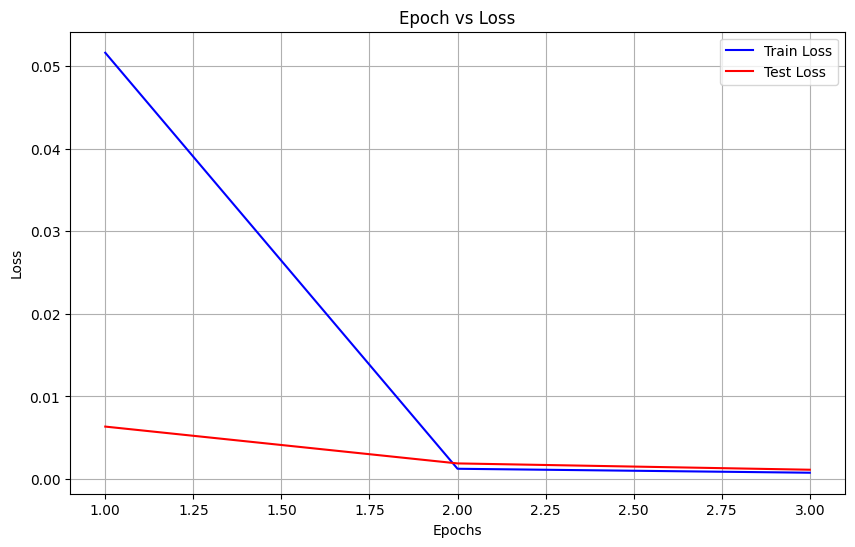

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ETSFORMER yükleme
file_path = "alibeyBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)  # Hangi sütunların seçildiğini kontrol edebilirsiniz

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Doğru yazım: __init__
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Doğru yazım: __len__
        return len(self.X)

    def __getitem__(self, index):  # Doğru yazım: __getitem__
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Basit bir ETSFormer modeli (örnek olarak LSTM temelli)
class SimpleETSFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Doğru yazım: __init__
        super(SimpleETSFormer, self).__init__()  # Doğru yazım: __init__
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64
output_dim = 1  # Baraj doluluk yüzdesi

model = SimpleETSFormer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Eğitim ve test kayıplarını saklamak için listeler
train_losses = []
test_losses = []

# Eğitim ve test metriklerini saklamak için listeler
train_mse, train_mape, train_mae, train_rmse, train_r2 = [], [], [], [], []
test_mse, test_mape, test_mae, test_rmse, test_r2 = [], [], [], [], []

# Model eğitimi ve değerlendirme
epochs = 3
for epoch in range(epochs):
    start_train_time = time.time()  # Eğitim başlangıç zamanı
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())

    # Eğitim süresi
    train_time = time.time() - start_train_time

    # Eğitim metriklerini hesapla
    train_mse.append(mean_squared_error(train_actuals, train_preds))
    train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)
    train_mae.append(mean_absolute_error(train_actuals, train_preds))
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals, train_preds)))
    train_r2.append(r2_score(train_actuals, train_preds))

    # Eğitim kaybını kaydetme
    train_losses.append(train_loss / len(train_loader))

    # Test değerlendirme
    start_test_time = time.time()  # Test başlangıç zamanı
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())

    # Test süresi
    test_time = time.time() - start_test_time

    # Test metriklerini hesapla
    test_mse.append(mean_squared_error(test_actuals, test_preds))
    test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)
    test_mae.append(mean_absolute_error(test_actuals, test_preds))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals, test_preds)))
    test_r2.append(r2_score(test_actuals, test_preds))

    # Test kaybını kaydetme
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse[-1]}, Test MSE: {test_mse[-1]}")
    print(f"Train MAPE: {train_mape[-1]}%, Test MAPE: {test_mape[-1]}%")
    print(f"Train MAE: {train_mae[-1]}, Test MAE: {test_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}, Test RMSE: {test_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}, Test R²: {test_r2[-1]}")
    print(f"Training time for epoch {epoch+1}: {train_time:.2f} seconds")
    print(f"Inference time for epoch {epoch+1}: {test_time:.2f} seconds")

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

Index(['datetime', 'temp', 'dew', 'humidity', 'precip', 'windspeedmean',
       'sealevelpressure', 'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')
            temp  dew  humidity  precip  windspeedmean  sealevelpressure  \
datetime                                                                   
2011-01-01   4.0 -0.5      73.9   0.000            9.2            1020.4   
2011-01-02   8.2  1.1      61.1   0.000           15.5            1015.9   
2011-01-03   7.7  3.7      77.2   2.691           15.9            1011.9   
2011-01-04   5.1  2.6      84.0   6.818           26.7            1019.3   
2011-01-05   5.9 -0.3      64.9   0.000           21.4            1023.6   

            cloudcover  daylight_duration  doluluk  weighted_score  
datetime                                                            
2011-01-01         8.0         556.666667    42.48        178.6650  
2011-01-02        38.1         557.400000    42.71        180.6030  
2011-01-03        89.2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                doluluk   No. Observations:                 3323
Model:                ARIMA(10, 1, 5)   Log Likelihood               -2804.882
Date:                Fri, 03 Jan 2025   AIC                           5641.764
Time:                        05:03:40   BIC                           5739.497
Sample:                    01-01-2011   HQIC                          5676.736
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0514      0.385     -0.133      0.894      -0.806       0.704
ar.L2          0.0073      0.265      0.028      0.978      -0.512       0.527
ar.L3          0.4403      0.238      1.851      0.0

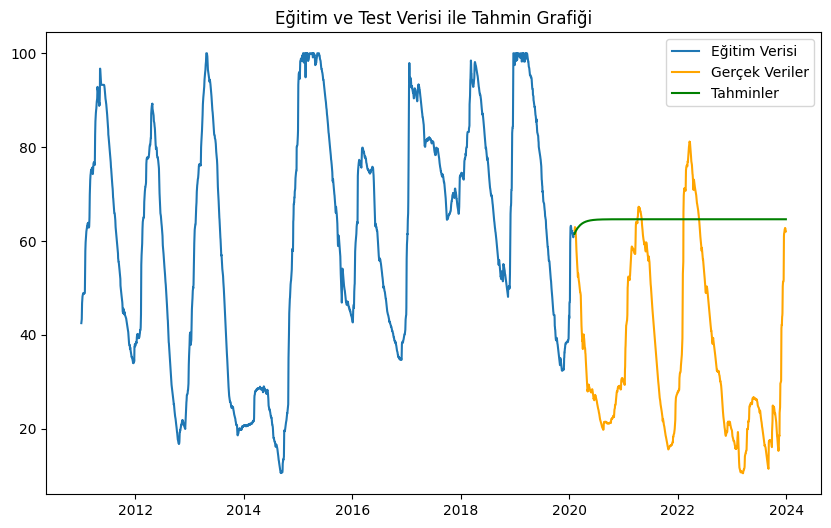

Mean Squared Error (MSE): 1187.2618831835748
Root Mean Squared Error (RMSE): 34.45666674511008
Mean Absolute Error (MAE): 30.47507031133646
Mean Absolute Percentage Error (MAPE): 1.3723311094318429%
R²: -2.5239094405718525
Eğitim Süreti: 22.14707589149475 saniye
Çıkarım Süreti: 0.07419300079345703 saniye


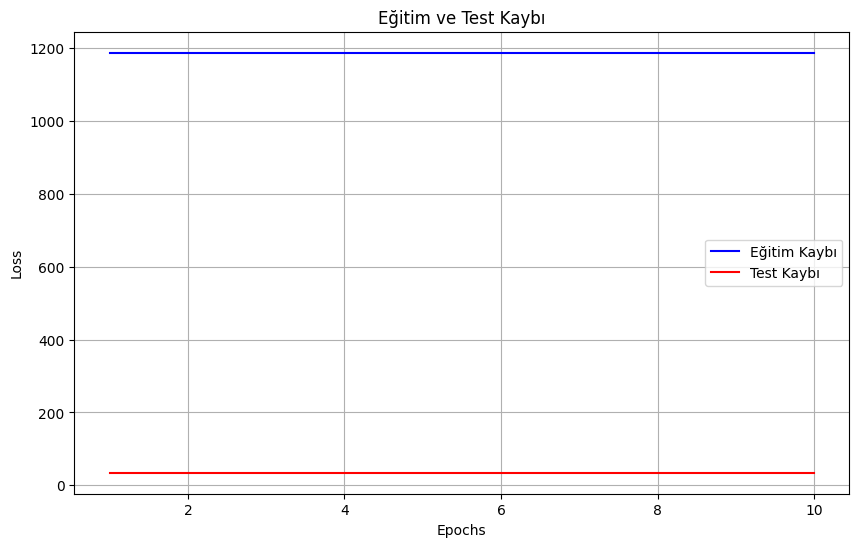

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import time

# ARIMA MODELLEMESI
df = pd.read_excel('alibeyBarajı.xlsx')
print(df.columns)

# Tarih sütununu datetime formatına çevirin
df['datetime'] = pd.to_datetime(df['datetime'])

# Veriyi tarihe göre sıralama
df = df.sort_values(by='datetime')

# Ağırlıkları belirleyin
weights = {
    'temp': 0.4,

    'dew': 0.05,
    'humidity': 0.1,
    'precip': 0.7,
    'windspeedmean': 0.05,
    'sealevelpressure': 0.1,
    'cloudcover': 0.05,
    'daylight_duration': 0.12
}

# Baraj doluluk yüzdesi ve diğer bağımsız değişkenler
df = df[['datetime', 'temp', 'dew', 'humidity', 'precip',
       'windspeedmean', 'sealevelpressure', 'cloudcover', 'daylight_duration',
       'doluluk']]

# Ağırlıklı skor hesaplama
df['weighted_score'] = (weights['temp'] * df['temp'] +

                        weights['dew'] * df['dew'] +
                        weights['humidity'] * df['humidity'] +
                        weights['precip'] * df['precip'] +
                        weights['windspeedmean'] * df['windspeedmean'] +
                        weights['sealevelpressure'] * df['sealevelpressure'] +
                        weights['cloudcover'] * df['cloudcover'] +
                        weights['daylight_duration'] * df['daylight_duration'])

# Tarihi indeks olarak ayarlayın
df.set_index('datetime', inplace=True)

# Veriye göz atın
print(df.head())

# Baraj doluluk yüzdesi kolonunu hedef olarak seçin
y = df['doluluk']

# Veriyi eğitim ve test setlerine ayırın (shuffle=False)
train, test = train_test_split(y, test_size=0.3, shuffle=False)

# Eğitim ve test zamanlaması
start_time = time.time()  # Eğitim zamanını başlatma

# ARIMA modelini tanımlayın
model = ARIMA(train, order=(10,1,5)) #2 yıla göre tahmin eder 1 fark ile q=2 ise geçmiş hatalarla ilgilenmedir

# Modeli eğitin
model_fit = model.fit()

# Eğitim süreti
end_time = time.time()
training_time = end_time - start_time  # Eğitim süreti hesaplama

# Modelin özetine göz atın
print(model_fit.summary())

# Test verisi üzerinde tahmin yapın
start_inference_time = time.time()  # Çıkarım (inference) zamanını başlatma
predictions = model_fit.forecast(steps=len(test))
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time  # Çıkarım süreti

# Tahminleri görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Eğitim Verisi')
plt.plot(test.index, test, label='Gerçek Veriler', color='orange')
plt.plot(test.index, predictions, label='Tahminler', color='green')
plt.legend()
plt.title('Eğitim ve Test Verisi ile Tahmin Grafiği')
plt.show()

# Modelin başarımını değerlendirelim
mse = mean_squared_error(test, predictions)
mse_rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(test, predictions)  # MAE
mape = mean_absolute_percentage_error(test, predictions)  # MAPE
r2 = r2_score(test, predictions)  # R²

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {mse_rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R²: {r2}')
print(f'Eğitim Süreti: {training_time} saniye')
print(f'Çıkarım Süreti: {inference_time} saniye')

# Sonuçları Excel dosyasına kaydetme
result_df = pd.DataFrame({
    'Gerçek Değerler': test,
    'Tahminler': predictions
})

result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=True)

# Kaybın (Loss) Grafiği
epochs = 10
train_losses = [mse] * epochs
test_losses = [mse_rmse] * epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Eğitim Kaybı", color='blue')
plt.plot(range(1, epochs + 1), test_losses, label="Test Kaybı", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim ve Test Kaybı")
plt.legend()
plt.grid(True)
plt.show()